In [177]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
dataset = torchvision.datasets.CIFAR10(root="./CIFAR10/data/", download = True, train = False)

Files already downloaded and verified


In [41]:
type(dataset[1][0])
dataset[0]

(<PIL.Image.Image image mode=RGB size=32x32>, 3)

In [35]:
type(v2.ToImage()(dataset[0][0]))

torchvision.tv_tensors._image.Image

In [38]:
v2.ToImage()(dataset[0][0]).shape

torch.Size([3, 32, 32])

In [42]:
v2.ToImage()(dataset[0][0])[0,0,0]

tensor(158, dtype=torch.uint8)

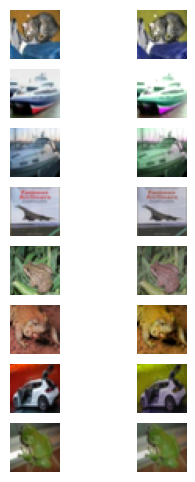

In [38]:
fig = plt.figure(figsize=(3,6))

trs = v2.Compose([v2.ToImage(),v2.ColorJitter(brightness = 0.2, contrast = 0.3, saturation = 0.4, hue = 0.2)])

for i in range(8):
    fig.add_subplot(8,2,2*i+1)
    plt.axis("off")
    plt.imshow(v2.ToImage()(dataset[i][0]).permute((1,2,0)))
    fig.add_subplot(8,2,2*i+2)
    plt.axis("off")
    plt.imshow(trs(dataset[i][0]).permute((1,2,0)))
    

In [230]:
to_tensor = v2.Compose([v2.ToImage(),v2.ToDtype(torch.float32, scale=True)])

#data_transform = v2.Compose([to_tensor, v2.RandomHorizontalFlip(p=0.5),
#                             v2.ColorJitter(brightness = 0.2, contrast = 0.3, saturation = 0.4, hue = 0.2)])

data_transform = v2.Compose([to_tensor, v2.Normalize([0,0,0],[256,256,256])])

In [231]:
dataset_train = torchvision.datasets.CIFAR10(root="./CIFAR10/data/", download = True, train = True, transform = data_transform)

dataset_test = torchvision.datasets.CIFAR10(root="./CIFAR10/data/", download = True, train = False, transform = data_transform)

fixed_generator = torch.Generator().manual_seed(55)

dataset_train, dataset_val = torch.utils.data.random_split(dataset_train, [0.9,0.1], generator = fixed_generator)

Files already downloaded and verified
Files already downloaded and verified


In [206]:
print(len(dataset_train), len(dataset_val), len(dataset_test))

45000 5000 10000


In [207]:
batch_size = 128

train_dataloader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = True)

val_dataloader = DataLoader(dataset = dataset_train, batch_size = batch_size, shuffle = False)

test_dataloader = DataLoader(dataset = dataset_test, batch_size = batch_size, shuffle = False)

In [145]:
class ConvModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv1 = torch.nn.Conv2d(3,3,3,padding='same')
        self.Pool = torch.nn.MaxPool2d(2,2)
        self.Conv2 = torch.nn.Conv2d(3,4,3,padding='same')
        self.Conv3 = torch.nn.Conv2d(4,6,3, padding='same')
        #self.Linear1 = torch.nn.Linear(320,20)
        #self.Linear2 = torch.nn.Linear(20,10)
        self.Linear1 = torch.nn.Linear(96,10)
        self.ReLU = torch.nn.ReLU()
        self.Flatten = torch.nn.Flatten()
        
    def forward(self, X):
        X = self.Pool(self.ReLU(self.Conv1(X)))
        X = self.Pool(self.ReLU(self.Conv2(X)))
        X = self.Pool(self.ReLU(self.Conv3(X)))
        X = self.Flatten(X)
        X = self.Linear1(X)
        #X = self.ReLU(self.Linear2(X))
        return X
        

In [146]:
if torch.cuda.is_available() == True:
    device = 'cuda'
else:
    device = 'cpu'

model1 = ConvModel()

model1 = model1.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model1.parameters())

In [161]:
def training_loop(model, dataloader, loss, optimizer, num_epochs, history = None):
    for epoch in range(num_epochs):
        
        if history is not None:
            correct_predictions = 0
            total_loss = 0
        
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            
            pred = model(data)
            l = loss(pred, labels)
            
            l.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            if history is not None:
                with torch.no_grad():
                    total_loss += l
                    correct_predictions += torch.sum(torch.argmax(pred, dim = 1) == labels)
                
        if history is not None:
            history['loss'].append(total_loss)
            history['accuracy'].append(correct_predictions/len(dataloader.dataset))
        
                
            
def test_loop(model, dataloader, loss, history = None):
    with torch.no_grad():     
    
        correct_predictions = 0
        total_loss = 0

        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            
            pred = model(data)
            
            total_loss+=loss(pred,labels)
            correct_predictions += torch.sum(torch.argmax(pred, dim = 1) == labels)
            
        accuracy = correct_predictions/len(dataloader.dataset)
            
        if history is not None:
            history['loss'].append(total_loss)
            history['accuracy'].append(correct_predictions/len(dataloader.dataset))
            
        return (total_loss, accuracy)
        
def plot_accuracy(history):
    plt.plot(np.arange(len(history['accuracy'])), history['accuracy'])

def plot_loss(history):
    plt.plot(np.arange(len(history['loss'])), history['loss'])    

In [151]:
#history1 = {'loss': [], 'accuracy': []}

In [170]:
num_epochs = 10

training_loop(model1, train_dataloader, loss, optimizer, num_epochs, history = history1)

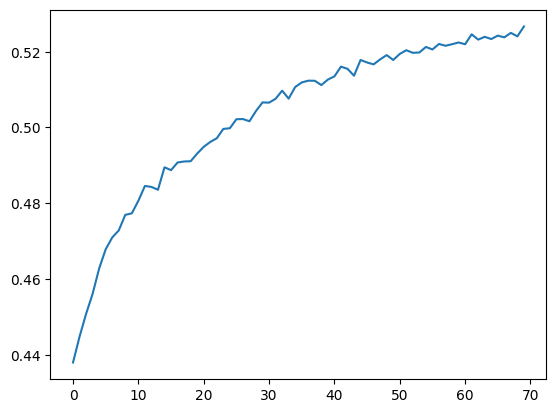

In [171]:
plot_accuracy(history1)

In [124]:
pytorch_total_params = sum(p.numel() for p in model1.parameters())
pytorch_total_params

1388

In [163]:
history2 = {'loss': [], 'accuracy': []}

In [172]:
test_loop(model1, test_dataloader, loss, history = history2)

(tensor(107.9542), tensor(0.5140))

In [175]:
checkpoint = {"epoch" : 70, "model_state": model1.state_dict(), "optimizer_state": optimizer.state_dict()}

In [192]:
path = "./CIFAR-10_Conv-Net_Model_checkpoints"
os.makedirs(path, exist_ok = True)

torch.save(checkpoint, os.path.join(path, "checkpoint1.pth"))

In [193]:
def save_checkpoint(model, optimizer, epoch, history, device, path, filename):
    checkpoint = {"epoch" : epoch, "model_state": model.state_dict(), "optimizer_state": optimizer.state_dict(),
                 "device": device, "history": history}
    
    os.makedirs(path, exist_ok = True)
    torch.save(checkpoint, os.path.join(path,filename))

In [194]:
save_checkpoint(model1, optimizer, 70, history, device, path, "checkpoint1.pth")

In [195]:
checkpoint = torch.load(os.path.join(path, "checkpoint1.pth"))

In [196]:
checkpoint.keys()

dict_keys(['epoch', 'model_state', 'optimizer_state', 'device', 'history'])

In [198]:
loaded_model = ConvModel()
loaded_model.load_state_dict(checkpoint['model_state'])

loaded_optimizer = torch.optim.Adam(loaded_model.parameters())
loaded_optimizer.load_state_dict(checkpoint['optimizer_state'])

In [201]:
test_loop(loaded_model, test_dataloader, loss)

(tensor(107.9542), tensor(0.5140))

In [202]:
#model saved as checkpoint1 has been trained without applying normalization to input tensors

In [203]:
#Let's try more general class allowing to specify layer sizes.

In [223]:
class ConvModelCustomizable(torch.nn.Module):
    def __init__(self, conv1, conv2, conv3, lin1):
        super().__init__()
        self.Conv1 = torch.nn.Conv2d(3,conv1,3,padding='same')
        self.Pool = torch.nn.MaxPool2d(2,2)
        self.Conv2 = torch.nn.Conv2d(conv1,conv2,3,padding='same')
        self.Conv3 = torch.nn.Conv2d(conv2,conv3,3, padding='same')
        self.Linear1 = torch.nn.Linear(4*4*conv3,lin1)
        self.Linear2 = torch.nn.Linear(lin1,10)
        self.ReLU = torch.nn.ReLU()
        self.Flatten = torch.nn.Flatten()
        
    def forward(self, X):
        X = self.Pool(self.ReLU(self.Conv1(X)))
        X = self.Pool(self.ReLU(self.Conv2(X)))
        X = self.Pool(self.ReLU(self.Conv3(X)))
        X = self.Flatten(X)  
        X = self.ReLU(self.Linear1(X))
        X = self.Linear2(X)
        return X

In [243]:
layer_sizes = {'conv1': 3, 'conv2': 6, 'conv3': 10, 'lin1': 20}


In [244]:
model2 = ConvModelCustomizable(**layer_sizes)

optimizer2 = torch.optim.Adam(model2.parameters())

train_history2 = {'loss': [], 'accuracy': []}

In [245]:
pytorch_total_params = sum(p.numel() for p in model2.parameters())
pytorch_total_params

4232

In [270]:
n_epochs = 50

training_loop(model2, train_dataloader, loss, optimizer2, n_epochs, train_history2)

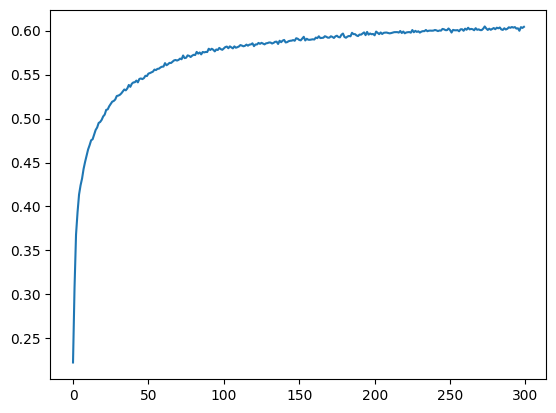

In [271]:
plot_accuracy(train_history2)

In [274]:
save_checkpoint(model2, optimizer2, epoch = 300, history = train_history2, device = 'cpu', 
                path = "./CIFAR-10_Conv-Net_Model_checkpoints", filename = "model2_checkpoint.pth")

In [275]:
#Let's try transfer learning

In [291]:
model3 = torchvision.models.resnet18(pretrained = True)

train_history3 = {'loss': [], 'accuracy': []}

In [292]:
model3.fc.in_features

512

In [293]:
for layer in model3.parameters():
    layer.requires_grad = False
model3.fc = torch.nn.Linear(512,10)

optimizer3 = torch.optim.Adam(model3.parameters())

In [303]:
n_epochs = 16

training_loop(model3, train_dataloader, loss, optimizer3, n_epochs, train_history3)

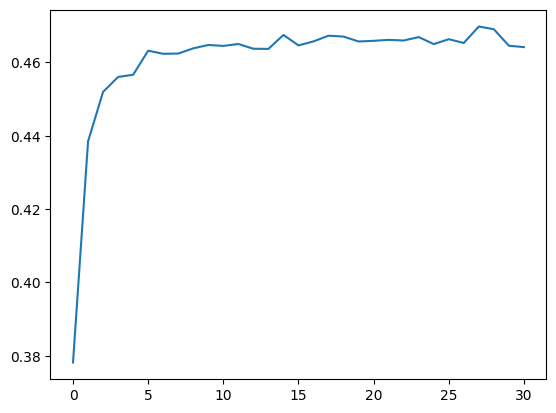

In [304]:
plot_accuracy(train_history3)

ResNet18 seems to perform very poorly on CIFAR-10. Why? Probably because it is designed for images with better resolution than 32x32.
Rescaling the data to fit the model creates huge "pixels" that do not represent any low-level features that first layers of model is trained to recognize.